In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import PIL
import cv2


In [3]:
import os 
print(os.listdir("input"))

path_train = os.listdir("input/train")
path_test = os.listdir("input/test")

['.DS_Store', 'test', 'sample_submission_v2.csv', 'train', 'train_ship_segmentations_v2.csv']


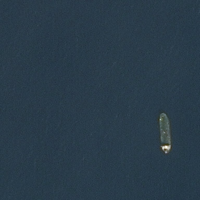

In [4]:
first_image = str(path_train[220])
PIL.Image.open("input/train/" + first_image).resize((200, 200))

In [5]:
# Import the dataframe with segmentation data which represents the masks
df_train_segm = pd.read_csv("input/train_ship_segmentations_v2.csv").dropna()
df_train_segm = df_train_segm.set_index('ImageId')
print(df_train_segm.head())
train_ids = df_train_segm.index.values

                                                   EncodedPixels
ImageId                                                         
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


Text(0.5, 1.0, 'Training dataset')

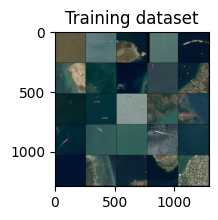

In [6]:
h = 5
w = 5
tile_height = 256 
tile_width = 256 
gap = 2

train_ids_rand = list(train_ids)
random.shuffle(train_ids_rand)


def load_img(filename):
    try:
        img = np.array(PIL.Image.open("input/train/" + filename).resize((tile_height, tile_width)))
        return img
    except:
        print("Error loading image: " + filename)
        return np.zeros((tile_height, tile_width, 3), dtype=np.uint8)

#3 dimensions is RGB
complete_image = np.zeros((h*(tile_height + gap), w*(tile_width + gap), 3), dtype=np.uint8)

#Loading images
img_index = 0
for i in range(h):
    y_start = i*(tile_height + gap)
    y_end = y_start + tile_height
    for j in range(w):
        x_start = j*(tile_width + gap)
        x_end = x_start + tile_width
        if img_index < len(train_ids):
            img = load_img(str(train_ids_rand[img_index]))
            complete_image[y_start:y_end, x_start:x_end, :] = img
            img_index += 1

plt.figure(figsize=(2, 2))
plt.imshow(complete_image)
plt.title("Training dataset")


In [7]:
if df_train_segm.index.name == 'ImageId':
    df_train_segm = df_train_segm.reset_index()
if df_train_segm.index.name != 'ImageId':
    df_train_segm = df_train_segm.set_index('ImageId')

df_train_segm.head()

def rle_decode(rle_codes, decoded_masks):
    for rle_code in rle_codes:
        rle_code = [int(i) for i in rle_code.split()]
        start_vals = rle_code[0:-1:2]  # Start element:stop element:step
        end_vals = rle_code[1::2]  # No stop element, so it will go to the end

        start_end = list(zip(start_vals, end_vals))

        for start, end in start_end:
            mask_pixels = range(start, start + end)
            mask_coords = [(pixel_pos % 768, pixel_pos // 768) for pixel_pos in mask_pixels]

            for x, y in mask_coords:
                decoded_masks[y, x] = 1 # Set the decoded mask pixel to 1, meaning that it contains ship

def mask_overlay(image, mask):
    mask = np.expand_dims(mask,axis=2)
    mask = (mask * 255).astype('uint8')
    # Convert the mask to 3 channels
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # Create a colored mask (you can choose different colors)
    colored_mask = mask_rgb * np.array([1, 0, 0])  # Red color
    # Apply the mask to the image using cv2.addWeighted()
    img_masked = cv2.addWeighted(image, 1, colored_mask, 0.5, 0)
    return img_masked
    

img_index = 0
for i in range(h): 
    y_start = i*(tile_height + gap)
    y_end = y_start + tile_height
    for j in range(w):
        x_start = j*(tile_width + gap)
        x_end = x_start + tile_width
        if img_index < len(train_ids):
            decoded_masks = np.zeros((768, 768)) # Emty array of zeros in which the decoded mask will be stored
            img_rle = df_train_segm.loc[train_ids_rand[img_index], "EncodedPixels"]  # Accessing Encoded pixels of the current image and converting to list in case there are multiple masks
            
            if isinstance(img_rle, str):
                # If it's a string, convert it to a list with a single element
                img_rle = [img_rle]
            else:
                # If it's a series, convert the whole series to a list
                img_rle = img_rle.tolist()
            
            for rle in img_rle:
                rle_decode(img_rle, decoded_masks)

            decoded_masks = np.expand_dims(decoded_masks,axis=2)

            img = load_img(str(train_ids_rand[img_index]))
            img_masked = mask_overlay(img, decoded_masks)  # Apply the overlay

            complete_image[y_start:y_end, x_start:x_end, :] = img
            img_index += 1

: 

: 